# 연습문제 풀이

## #01. 작업준비

### 패키지 설치

In [1]:
import sys
sys.path.append("../../")

from datetime import datetime as dt
from datetime import timedelta
from pandas import read_excel, to_datetime
from matplotlib import pyplot as plt
from matplotlib import dates as mdates
from statsmodels.tsa.arima.model import ARIMA 
from pmdarima.arima import auto_arima
import seaborn as sb

from helper import set_datetime_index, exp_time_data

### 데이터 가져오기

In [5]:
df = read_excel("https://data.hossam.kr/E06/temperatures_seoul.xlsx", index_col='날짜')
df

,평균기온(℃)
날짜,
1973-07-01,22.7
1973-07-02,23.8
1973-07-03,27.2
1973-07-04,25.2
1973-07-05,26.9
...,...
2023-08-02,29.7
2023-08-03,29.5
2023-08-04,30.0


### 결측치 확인

In [6]:
df.isna().sum()
# 확인 결과 결측치 없음!

평균기온(℃)    0
dtype: int64

### 데이터 검정
> 데이터가 너무 많으므로 최신 1000건만으로 검정을 시도함

In [13]:
df2 = df.tail(365*5)
df2.head()

,평균기온(℃)
날짜,
2018-08-08,31.0
2018-08-09,28.8
2018-08-10,30.7
2018-08-11,31.0
2018-08-12,30.6


In [8]:
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['font.size'] = 12
plt.rcParams['axes.unicode_minus'] = False

결측치 수 : 0


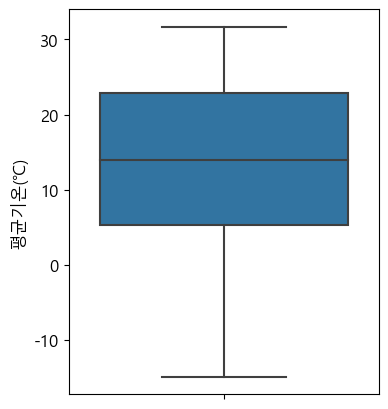

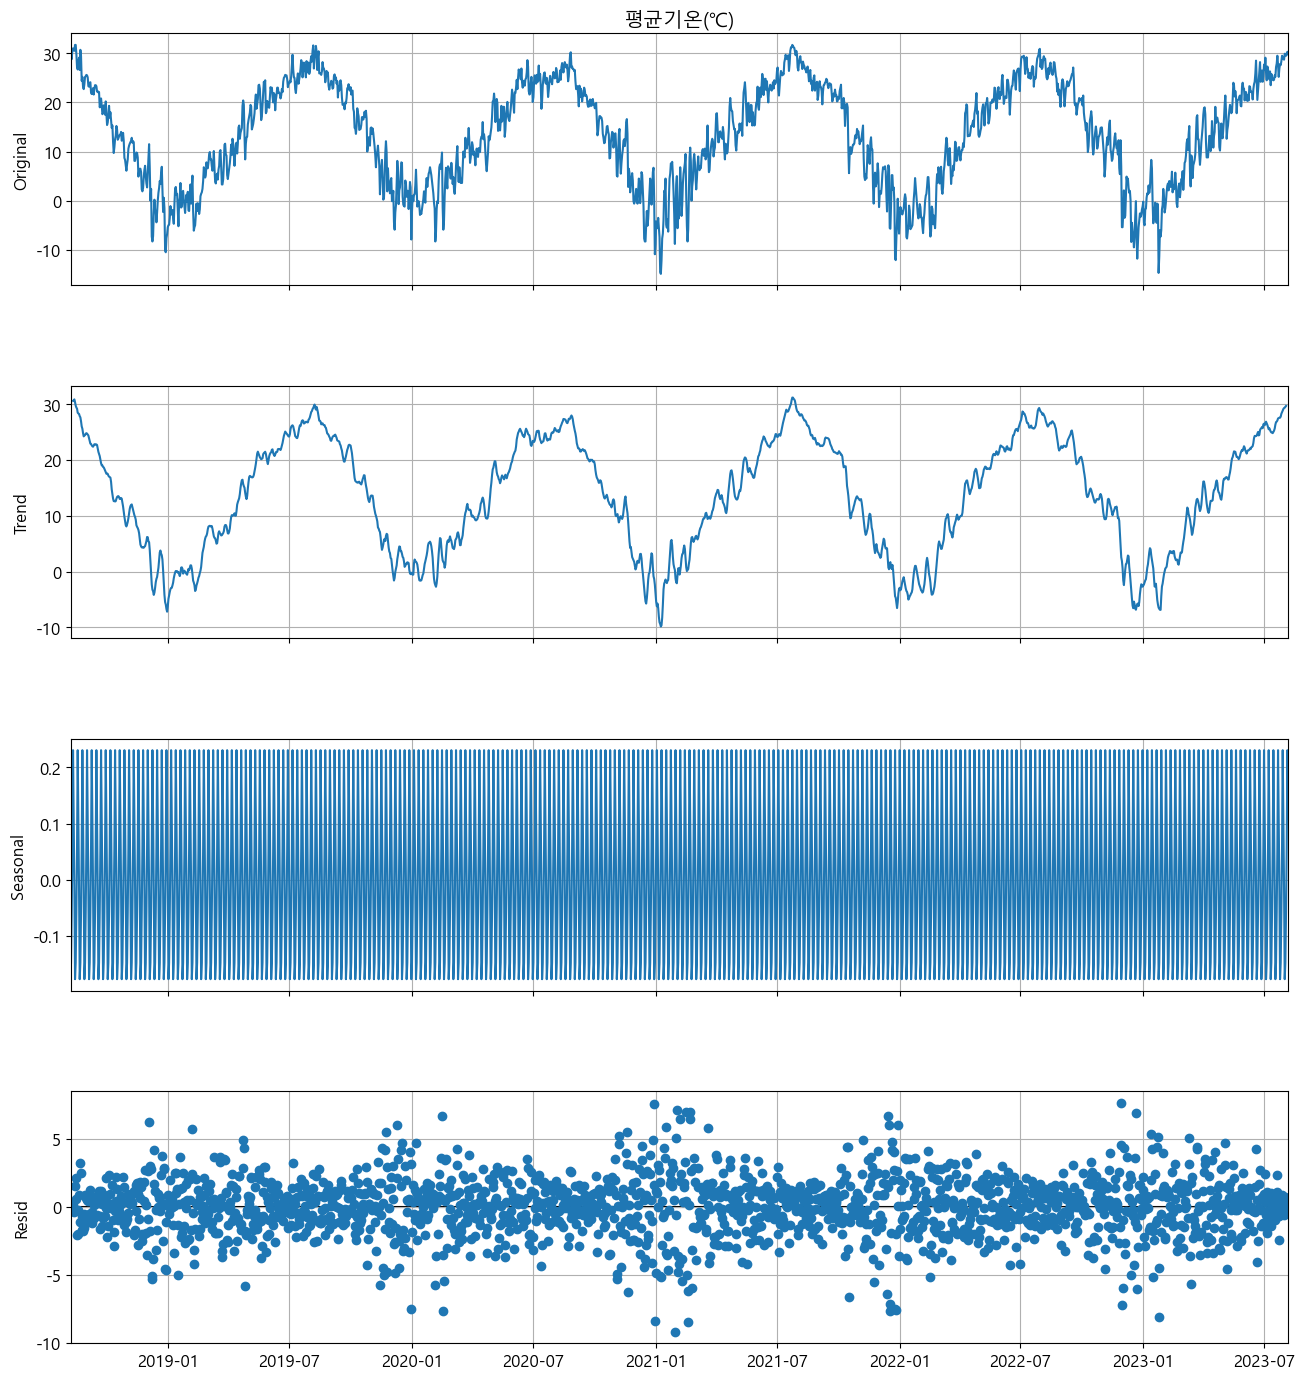

========= 원본 데이터 ===========
+------------------------------------+----------+
| ADF Test                           |          |
|------------------------------------+----------|
| 검정통계량(ADF Statistic)          | -2.00483 |
| 유의수준(p-value)                  | 0.284458 |
| 최적차수(num of lags)              |       19 |
| 관측치 개수(num of observations)   |     1805 |
| 기각값(Critical Values) 1%         | -3.43398 |
| 기각값(Critical Values) 5%         | -2.86314 |
| 기각값(Critical Values) 10%        | -2.56762 |
| 데이터 정상성 여부(0=False,1=True) |        0 |
+------------------------------------+----------+


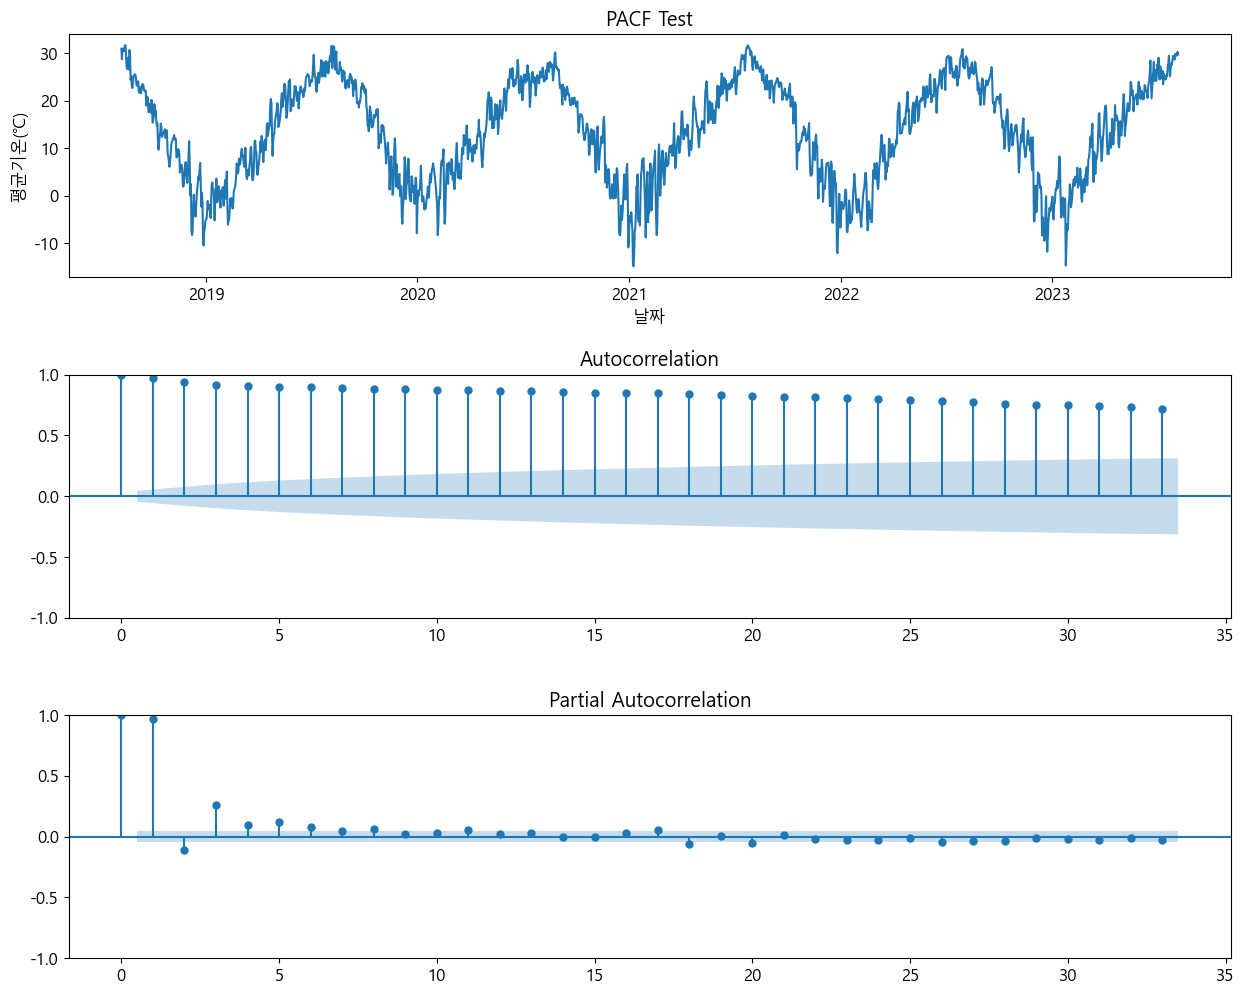

========= 1차 차분 데이터 ===========
+------------------------------------+-------------+
| ADF Test                           |             |
|------------------------------------+-------------|
| 검정통계량(ADF Statistic)          |    -11.4068 |
| 유의수준(p-value)                  | 7.41633e-21 |
| 최적차수(num of lags)              |          18 |
| 관측치 개수(num of observations)   |        1805 |
| 기각값(Critical Values) 1%         |    -3.43398 |
| 기각값(Critical Values) 5%         |    -2.86314 |
| 기각값(Critical Values) 10%        |    -2.56762 |
| 데이터 정상성 여부(0=False,1=True) |           1 |
+------------------------------------+-------------+


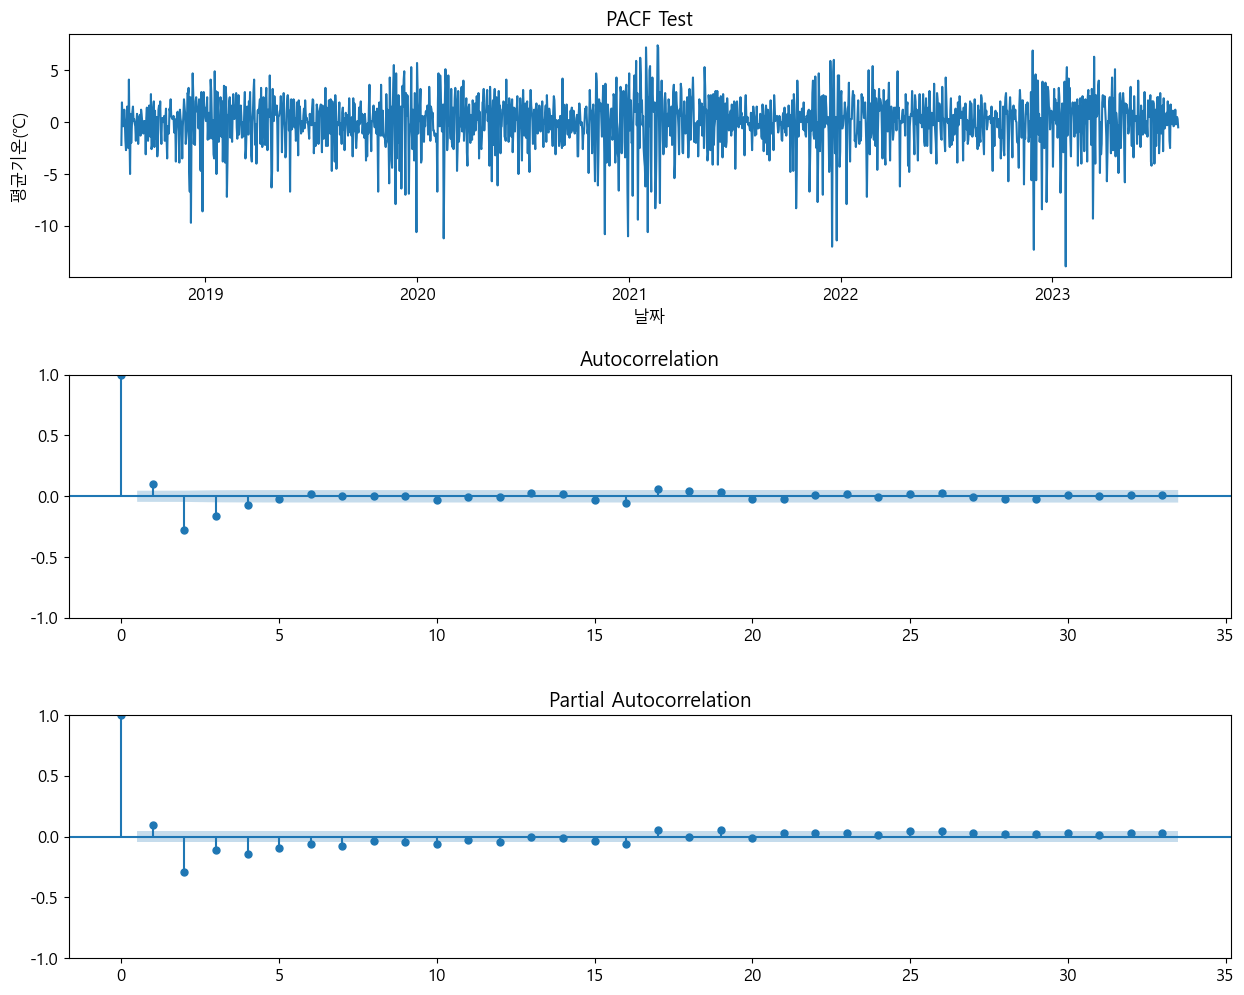

In [14]:
exp_time_data(data=df2, yname="평균기온(℃)", sd_model="a", max_diff=10)

### ARIMA 분석

#### 분석모델 만들기
> 날씨에 대한 데이터이므로 계절성은 1년마다 돌아온다고 보는 것이 맞지만 컴퓨터 성능상의 한계로 계절성을 1주일 단위(=7일)로 제한함.

In [15]:
model = ARIMA(df2['평균기온(℃)'], order=(1,1,0), seasonal_order=(1,1,0,30))
fit = model.fit()
print(fit.summary())

c:\Users\hanjieun_2\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\hanjieun_2\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\hanjieun_2\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                                    SARIMAX Results                                     
Dep. Variable:                          평균기온(℃)   No. Observations:                 1825
Model:             ARIMA(1, 1, 0)x(1, 1, 0, 30)   Log Likelihood               -4498.487
Date:                          Tue, 08 Aug 2023   AIC                           9002.974
Time:                                  12:43:28   BIC                           9019.451
Sample:                              08-08-2018   HQIC                          9009.057
                                   - 08-06-2023                                         
Covariance Type:                            opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0862      0.020      4.333      0.000       0.047       0.125
ar.S.L30      -0.4916      0.017    -29.565      0.

### 학습 모델에 대한 예측치

In [16]:
fv = fit.fittedvalues
fv.head()

날짜
2018-08-08     0.000000
2018-08-09    31.000016
2018-08-10    28.799999
2018-08-11    30.700002
2018-08-12    31.000000
dtype: float64

### 학습한 내용을 토대로 1년간의 예상치 생성

In [17]:
fc = fit.forecast(365)
fc.head()

2023-08-07    28.685755
2023-08-08    29.648218
2023-08-09    30.412096
2023-08-10    28.447706
2023-08-11    29.666272
Freq: D, Name: predicted_mean, dtype: float64

### 시각화

In [18]:
last = df2.index.max()
xmin = last - timedelta(days=365)
xmax = last + timedelta(days=365+10)
ymax = df2['평균기온(℃)'][xmin:xmax].max()
ymin = df2['평균기온(℃)'][xmin:xmax].min()
xmin, xmax, ymax, ymin

(Timestamp('2022-08-06 00:00:00'),
 Timestamp('2024-08-15 00:00:00'),
 30.3,
 -14.7)

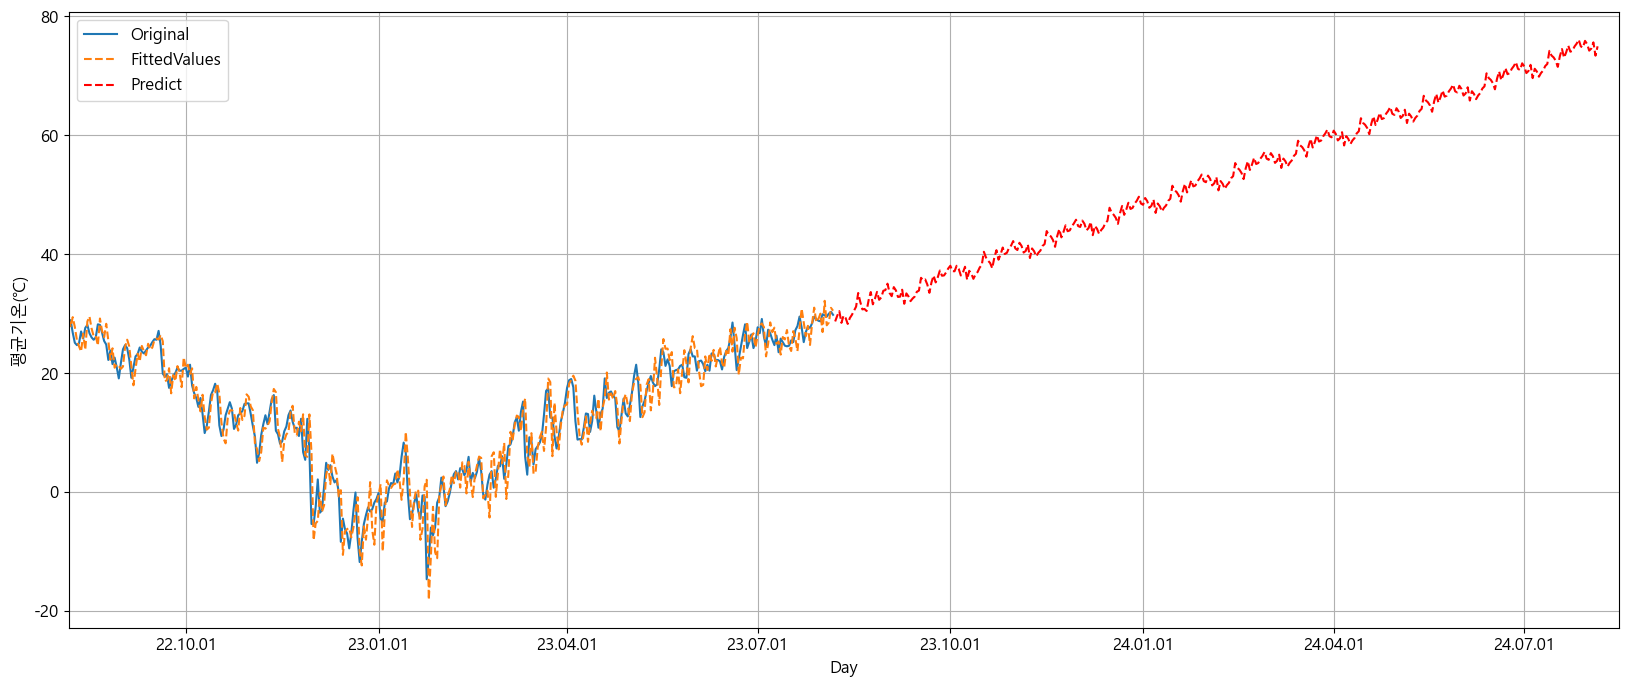

In [19]:
plt.figure(figsize=(20,8))

#원본데이터
sb.lineplot(data=df2, x=df2.index, y='평균기온(℃)', label='Original')

#원본에 대한 학습결과
sb.lineplot(x=fv.index, y=fv.values, label='FittedValues', linestyle='--')

#향후 1년간의 예측값
sb.lineplot(x=fc.index, y=fc.values, label='Predict', linestyle='--', color='red')

plt.xlabel('Day')
plt.ylabel('평균기온(℃)')
plt.legend()

plt.xlim([xmin,xmax])

#그래프의 x축이 날짜로 구성되어 있을 경우 형식 지정
monthyearFmt = mdates.DateFormatter('%y.%m.%d')
plt.gca().xaxis.set_major_formatter(monthyearFmt)

plt.grid()
plt.show()
plt.close()